# Variation Deep Embeddings

Paper Link - https://arxiv.org/abs/1611.05148

## Importing Libraries and Config File

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import math
import numpy as np

from tqdm import tqdm
from time import sleep

from includes.config import Config

import tensorflow as tf

from sklearn import mixture
from sklearn.manifold import TSNE

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

In [4]:
mpl.rc_file_defaults()

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
ds = tf.contrib.distributions
xav_init = tf.contrib.layers.xavier_initializer()

## Loading Data and Setting Parameters

In [7]:
def get_data(datagroup, **args):
    def spiral(dataset="spiral", N_tr=5000, N_ts=1000):
        D = 2
        K = 5
        X_tr = np.zeros((N_tr * K, D))
        X_ts = np.zeros((N_ts * K, D))

        for j in range(K):
            ix = range(N_tr * j, N_tr * (j + 1))
            r = np.linspace(2.5, 10.0, N_tr)
            t = np.linspace(j * 1.25, (j + 1) * 1.25, N_tr) + \
                np.random.randn(N_tr) * 0.05
            X_tr[ix] = np.c_[r * np.sin(t), r * np.cos(t)]

        for j in range(K):
            ix = range(N_ts * j, N_ts * (j + 1))
            r = np.linspace(2.5, 10.0, N_ts)
            t = np.linspace(j * 1.25, (j + 1) * 1.25, N_ts) + \
                np.random.randn(N_ts) * 0.05
            X_ts[ix] = np.c_[r * np.sin(t), r * np.cos(t)]

        return X_tr, X_ts

    def mnist(dataset="binary", dir="data/mnist"):
        from tensorflow.examples.tutorials.mnist import input_data

        mnist = input_data.read_data_sets("data/mnist/", one_hot=True)

        test_data = mnist.test.images
        train_data = mnist.train.images

        return train_data, test_data

    if datagroup == "spiral":
        return spiral(**args)
    elif datagroup == "mnist":
        return mnist(**args)
    else:
        assert(False)

In [8]:
class Dataset:
    def __init__(self, data, batch_size=100, shuffle=True):
        self.data = np.copy(data)
        self.batch_size = batch_size

        self.epoch_len = int(math.ceil(len(data) / batch_size))

        if shuffle:
            np.random.shuffle(self.data)

    def get_batches(self, shuffle=True):
        if shuffle:
            np.random.shuffle(self.data)

        batch = []
        for row in self.data:
            batch.append(row)
            if len(batch) == self.batch_size:
                yield np.array(batch)
                batch = []
        if len(batch) > 0:
            yield np.array(batch)

    def __len__(self):
        return self.epoch_len

In [9]:
import os
import numpy as np


class Config:
    def __init__(self, dataset="mnist"):
        if dataset == "mnist":
            self.input_dim = 784

            self.latent_dim = 10

            self.latent_prior_weights = np.zeros(
                self.latent_dim, dtype=float
            )


            self.n_epochs = 500
            self.batch_size = 200

            self.regularizer = 1

            self.encoder_hidden_size = [256, 256, 512]
            self.decoder_hidden_size = [512, 256]
            
            
            self.n_clusters = 10
            self.pretrain_vae_n_epochs = 500
            self.pretrain_gmm_n_iters = 500
            self.pretrain_gmm_n_inits = 5

            self.decay_steps = 10
            self.decay_rate = 0.9
            self.learning_rate = 0.002
            self.epsilon = 1e-04

        elif dataset == "spiral":
            self.input_dim = 2

            self.latent_dim = 7

            self.n_epochs = 500
            self.batch_size = 200
            
            self.n_clusters = 5
            self.pretrain_vae_n_epochs = 500
            self.pretrain_gmm_n_iters = 500
            self.pretrain_gmm_n_inits = 5

            self.regularizer = 1

            self.encoder_hidden_size = [256, 256, 512]
            self.decoder_hidden_size = [512, 256]

            self.decay_steps = 10
            self.decay_rate = 0.9
            self.learning_rate = 0.002
            self.epsilon = 1e-04

        if not os.path.exists("models/" + dataset):
            os.makedirs("models/" + dataset)

        self.train_dir = "models/" + dataset

In [10]:
dataset = "spiral"

In [11]:
conf = Config(dataset=dataset)

In [12]:
train_data, test_data = get_data(dataset)

train_data = Dataset(train_data, batch_size=conf.batch_size)
test_data = Dataset(test_data, batch_size=conf.batch_size)

## Visualizing the Data

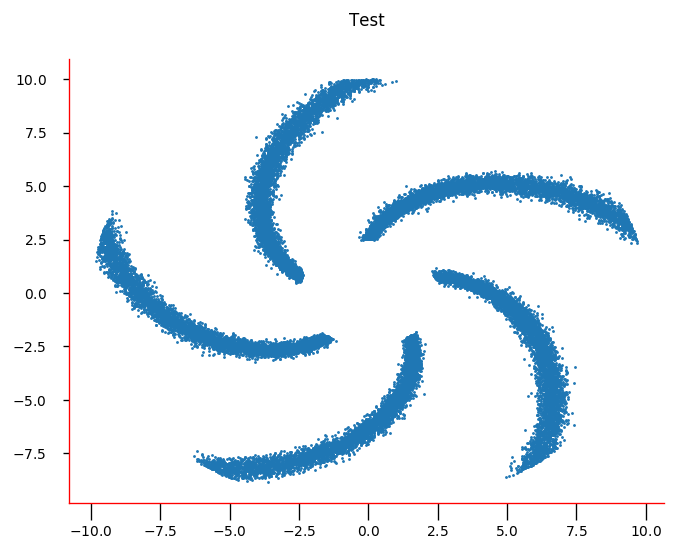

In [13]:
if dataset == "spiral":
    plt.scatter(train_data.data[:, 0], train_data.data[:, 1], s=0.5)
elif dataset == "mnist" or dataset == "mmnist":
    images = train_data.data[:100]
    if dataset == "mmnist":
        images = images[:, :-1]
    
    images = images.reshape((100, 28, 28))
    images = np.concatenate(images, axis=1)
    images = np.array([images[:, x:x+280] for x in range(0, 2800, 280)])
    images = np.concatenate(images, axis=0)
    images = np.concatenate(
        [np.zeros((280, 10)), images, np.zeros((280, 10))], axis=1
    )
    images = np.concatenate(
        [np.zeros((10, 300)), images, np.zeros((10, 300))], axis=0
    )

    plt.imshow(images, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.title("Test")
plt.savefig("test.png")
plt.show()

## Defining the Encoder

In [14]:
def encoder():
    global X
    
    h_encoders = [
        tf.layers.dense(
            X,
            conf.encoder_hidden_size[0],
            activation=tf.nn.relu,
            kernel_initializer=xav_init,
            name="encoder_hidden_layer_0"
        )
    ]
    
    for index, size in enumerate(conf.encoder_hidden_size[1:]):
        h_encoders.append(
            tf.layers.dense(
                h_encoders[index],
                size,
                activation=tf.nn.relu,
                kernel_initializer=xav_init,
                name="encoder_hidden_layer_" + str(index + 1)
            )
        )
    
    encoder_mean = tf.layers.dense(
        h_encoders[-1],
        conf.latent_dim,
        kernel_initializer=xav_init,
        name="encoder_mean"
    )
    encoder_log_var = tf.layers.dense(
        h_encoders[-1],
        conf.latent_dim,
        kernel_initializer=xav_init,
        name="encoder_log_variance"
    )
    
    return encoder_mean, encoder_log_var

## Defining the Decoder

In [16]:
def decoder():
    global Z
    
    h_decoders = [
        tf.layers.dense(
            Z,
            conf.decoder_hidden_size[0],
            activation=tf.nn.relu,
            kernel_initializer=xav_init,
            name="decoder_hidden_layer_0"
        )
    ]
    
    for index, size in enumerate(conf.decoder_hidden_size[1:]):
        h_decoders.append(
            tf.layers.dense(
                h_decoders[index],
                size,
                activation=tf.nn.relu,
                kernel_initializer=xav_init,
                name="decoder_hidden_layer_" + str(index + 1)
            )
        )
    
    out_X = tf.layers.dense(
        h_decoders[-1],
        conf.input_dim,
        kernel_initializer=xav_init,
        name="decoder_X"
    )
    
    return out_X, tf.nn.sigmoid(out_X)

## Sampling Z using the reparametrization trick

In [17]:
def sample_Z():
    global epsilon
    global encoder_mean, encoder_log_var
    
    return encoder_mean + tf.exp(encoder_log_var / 2) * epsilon

## Initializing and Learning the GMM Priors (Pretraining)

In [18]:
def init_prior():
    prior_means = tf.Variable(
        tf.random_normal((conf.n_clusters, conf.latent_dim), stddev=5.0),
        dtype=tf.float32,
        name="prior_means"
    )
    prior_vars = tf.Variable(
        tf.ones((conf.n_clusters, conf.latent_dim)),
        dtype=tf.float32,
        name="prior_vars"
    )
    prior_weights = tf.Variable(
        tf.ones((conf.n_clusters)) / conf.n_clusters,
        dtype=tf.float32,
        name="prior_weights"
    )
    
    return prior_means, prior_vars, prior_weights

In [19]:
def init_gmm_priors(Z=None, train=True):
    global init_gmm_model
    
    if train == True:
        init_gmm_model.fit(Z)
        
    return init_gmm_model

## Defining the Posterior of Cluster Assignments

In [20]:
def q_c():
    global Z
    global prior_means, prior_vars, prior_weights
    
    def fn_cluster(_, k):
        q = prior_weights[k] * ds.MultivariateNormalDiag(loc=prior_means[k], scale_diag=prior_vars[k]).prob(Z) + 1e-10
        return tf.reshape(q, [conf.batch_size])

    clusters = tf.Variable(tf.range(conf.n_clusters))
    probs = tf.scan(fn_cluster, clusters, initializer=tf.ones([conf.batch_size]))
    probs = tf.transpose(probs)
    probs = probs / tf.reshape(tf.reduce_sum(probs, 1), (-1, 1))
    return probs

## Defining the Loss Function

In [21]:
def vae_loss(dataset="mnist"):
    global cluster_weights
    global X, decoded_exp_X_mean
    global encoder_mean, encoder_log_var
    global prior_means, prior_vars, prior_weights
    
    J = 0.0
    if dataset == "mnist":
        J += conf.regularizer * tf.reduce_sum(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=X, logits=decoded_exp_X_mean
            ),
            axis=1
        )
    elif dataset == "spiral":
        J += conf.regularizer * tf.reduce_sum(
            tf.square(decoded_exp_X_mean - X),
            axis=1
        )
    J -= tf.reduce_sum(cluster_weights * tf.log(prior_weights), axis=1)
    J += tf.reduce_sum(cluster_weights * tf.log(cluster_weights), axis=1)
    J -= 0.5 * tf.reduce_sum(1 + encoder_log_var, axis=1)

    def fn_cluster(previous_output, current_input):
        k = current_input
        l = previous_output + 0.5 * cluster_weights[:, k] * tf.reduce_sum(
            tf.log(prior_vars[k]) + 
            (
                tf.exp(encoder_log_var) + 
                tf.square(encoder_mean - prior_means[k])
            ) / prior_vars[k], axis=1
        )
        return l

    clusters = tf.Variable(tf.range(conf.n_clusters))
    y = tf.scan(fn_cluster, clusters, initializer=tf.zeros(conf.batch_size))
    
    J += y[-1, :]
    
    return tf.reduce_mean(J)

## Defining the TensorFlow Graph

In [22]:
X = tf.placeholder(tf.float32, [None, conf.input_dim])
epsilon = tf.placeholder(tf.float32, [None, conf.latent_dim])

prior_means, prior_vars, prior_weights = init_prior()

encoder_mean, encoder_log_var = encoder()

Z = sample_Z()

decoded_exp_X_mean, decoded_X_mean = decoder()

cluster_weights = q_c()

In [23]:
loss = vae_loss(dataset)
learning_rate = tf.train.exponential_decay(
    learning_rate=conf.learning_rate,
    global_step=0,
    decay_steps=train_data.epoch_len * conf.decay_steps,
    decay_rate=conf.decay_rate
)

train_step = tf.train.AdamOptimizer(
    learning_rate=learning_rate, 
    epsilon=conf.epsilon
).minimize(loss)

## Defining the Pretraining Loss

In [24]:
if dataset == "mnist":
    pretrain_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=X, 
                logits=decoded_exp_X_mean
            ), axis=1
        ) + 0.5 * tf.reduce_sum(
            tf.exp(encoder_log_var) + encoder_mean ** 2 - 1. - encoder_log_var,
            axis=1
        )
    )
elif dataset == "spiral":
    pretrain_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.square(
                decoded_exp_X_mean - X
            ), axis=1
        ) + 0.5 * tf.reduce_sum(
            tf.exp(encoder_log_var) + encoder_mean ** 2 - 1. - encoder_log_var,
            axis=1
        )
    )

learning_rate = tf.train.exponential_decay(
    learning_rate=conf.learning_rate,
    global_step=0,
    decay_steps=train_data.epoch_len * conf.decay_steps,
    decay_rate=conf.decay_rate
)

pretrain_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(pretrain_loss)

## Defining functions for Plotting

In [29]:
colors = ["dimgray", "gainsboro", "firebrick", "maroon", "cadetblue", "orange", "burlywood", "mediumslateblue", "palevioletred", "navy"]

In [25]:
def regeneration_plot(data="mnist"):
    if not os.path.exists("plots/vade/" + dataset):
        os.makedirs("plots/vade/" + dataset)

    gs = grid.GridSpec(1, 2) 

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
        
    if data == "mnist":
        decoded_image = sess.run(
            decoded_X_mean,
            feed_dict={
                X: test_data.data[:100],
                epsilon: np.random.randn(100, conf.latent_dim)
            }
        )

        decoded_image = np.array(decoded_image).reshape((100, 784))
        figure = np.zeros((280, 280))

        for i in range(0, 10):
            for j in range(0, 10):
                figure[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = (
                    decoded_image[10 * i + j].reshape((28, 28)) * 255
                )

        ax2.imshow(figure, cmap="Greys_r")

        decoded_image = np.array(test_data.data[:100])
        figure = np.zeros((280, 280))

        for i in range(0, 10):
            for j in range(0, 10):
                figure[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = (
                    decoded_image[10 * i + j].reshape((28, 28)) * 255
                )

        ax1.imshow(figure, cmap="Greys_r")
        
    elif data == "spiral":
        decoded_X = sess.run(
            decoded_exp_X_mean,
            feed_dict={
                X: test_data.data,
                epsilon: np.random.randn(len(test_data.data), conf.latent_dim)
            }
        )
        
        ax1.scatter(test_data.data[:, 0], test_data.data[:, 1], s=0.5)
        ax2.scatter(decoded_X[:, 0], decoded_X[:, 1], s=0.5)
        
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2.spines['bottom'].set_visible(False)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.savefig("plots/vade/%s/regenerated.png" % dataset)
    plt.clf()

In [26]:
def sample_plot(dataset="mnist"):
    if not os.path.exists("plots/vade/" + dataset):
        os.makedirs("plots/vade/" + dataset)
    
    gs = grid.GridSpec(1, 2)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    mus, sigmas = sess.run([prior_means, prior_vars], feed_dict={})
    
    sigmas = np.sqrt(sigmas)
    
    if dataset == "mnist":
        sample_Z = list()
        decoded_X = list()
        for k in range(0, conf.n_clusters):
            s_Z = mus[k] + sigmas[k] * np.random.randn(1000, conf.latent_dim)
            sample_Z.append(s_Z)

            decoded_X.append(sess.run(
                decoded_X_mean,
                feed_dict={
                    Z: s_Z
                }
            ))

        sample_Z = np.concatenate(sample_Z, axis=0)
        if conf.latent_dim > 2:
            sample_Z = TSNE(n_components=2).fit_transform(sample_Z)
        
        sample_Z = sample_Z.reshape((conf.n_clusters, sample_Z.shape[0] // conf.n_clusters, 2))

        image = (
            1 - np.concatenate(
                np.concatenate(
                    np.array(decoded_X)[:, :10].reshape((10, 10, 28, 28)),
                    axis=1
                ), 
                axis=1
            )
        )

        ax1.imshow(image, cmap="Greys")

        for k in range(0, conf.n_clusters):
            ax2.scatter(sample_Z[k][:, 0], sample_Z[k][:, 1], s=0.5, color=colors[k])
        
    elif dataset == "spiral":
        eps = np.random.randn(conf.n_clusters, 1000, conf.latent_dim)
        
        sample_Z = np.concatenate(eps * sigmas[:, None, :] + mus[:, None, :], axis=0)
        
        decoded_X = sess.run(
            decoded_exp_X_mean,
            feed_dict={
                Z: sample_Z
            }
        )
        
        if conf.latent_dim > 2:
            sample_Z = TSNE(n_components=2).fit_transform(sample_Z)

        for k in range(0, conf.n_clusters):
            ax1.scatter(decoded_X[1000*k:1000*(k+1), 0], decoded_X[1000*k:1000*(k+1), 1], s=0.5)
            ax2.scatter(sample_Z[1000*k:1000*(k+1), 0], sample_Z[1000*k:1000*(k+1), 1], s=0.5)

    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2.spines['bottom'].set_visible(False)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.savefig("plots/vade/%s/sampled.png" % dataset)
    plt.clf()

## Starting the Session

In [27]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

## Pretraining for VAE parameters

In [28]:
with tqdm(range(conf.pretrain_vae_n_epochs), postfix={"loss": float("inf")}) as bar:
    for epoch in bar:
        J = 0.0
        for batch in train_data.get_batches():
            out = sess.run(
                [pretrain_loss, pretrain_step],
                feed_dict={
                    X: batch,
                    epsilon: np.random.randn(conf.batch_size, conf.latent_dim)
                }
            )
            J += out[0] / train_data.epoch_len

        if epoch % 100 == 0:
            regeneration_plot(dataset)

        bar.set_postfix({"loss": J})

100%|██████████| 500/500 [03:48<00:00,  2.14it/s, loss=4.02]


<Figure size 768x576 with 0 Axes>

## Pretraining for GMM parameters

In [30]:
lv = sess.run(Z, feed_dict={
    X: train_data.data,
    epsilon: np.random.randn(len(train_data.data), conf.latent_dim)
})
init_gmm_model = mixture.GaussianMixture(
    n_components=conf.n_clusters,
    covariance_type="diag",
    max_iter=conf.pretrain_gmm_n_iters,
        n_init=conf.pretrain_gmm_n_inits,
    weights_init=np.ones(conf.n_clusters) / conf.n_clusters,
)

init_gmm_means = tf.assign(prior_means, init_gmm_priors(Z=lv).means_)
init_gmm_vars = tf.assign(prior_vars, init_gmm_priors(train=False).covariances_)
init_gmm_weights = tf.assign(prior_weights, init_gmm_priors(train=False).weights_)

_ = sess.run([init_gmm_means, init_gmm_vars, init_gmm_weights], feed_dict={})

## Training the VaDE Model

In [31]:
with tqdm(range(500), postfix={"loss": float("inf")}) as bar:
    for epoch in bar:
        J = 0.0
        for batch in train_data.get_batches():
            out = sess.run(
                [loss, train_step],
                feed_dict={
                    X: batch,
                    epsilon: np.random.randn(conf.batch_size, conf.latent_dim)
                }
            )
            J += out[0] / train_data.epoch_len

        bar.set_postfix({"loss": J})
    
        if epoch % 50 == 0:
            sample_plot(dataset)
            regeneration_plot(dataset)

            
sample_plot(dataset)
regeneration_plot(dataset)

100%|██████████| 500/500 [27:17<00:00,  3.72s/it, loss=0.315] 


<Figure size 768x576 with 0 Axes>